**Table of contents**<a id='toc0_'></a>    
- [Setting up data and imports](#toc1_1_1_1_1_)    
      - [Optimization Setup](#toc1_1_1_2_)    
      - [SpOPT](#toc1_1_1_3_)    
      - [PyMOO Testing](#toc1_1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

##### <a id='toc1_1_1_1_1_'></a>[Setting up data and imports](#toc0_)

In [91]:
import pulp
import geopandas as gpd
import pandas as pd
import numpy as np
from importlib import reload

# Importing my modules
from src.main import classes, geometry_operations, optimization_functions, plotting_2d, plotting_3d

In [3]:
# %store -r line_gdf_reworked
%store -r line_gdf_75
%store -r harvesteable_trees_gdf
%store -r height_gdf
%store -r anchor_trees_gdf
%store -r target_trees_gdf
%store -r line_gdf_v1
%store -r slope_line

line_gdf = line_gdf_v1.copy()
# hack to extract this from the line_gdf
start_point_dict = dict(
    [(key, value.coords[0]) for key, value in enumerate(line_gdf["line_candidates"])]
)

#### <a id='toc1_1_1_2_'></a>[Optimization Setup](#toc0_)

In [92]:
bhd_series = harvesteable_trees_gdf["BHD"]
height_series = harvesteable_trees_gdf["h"].replace(",", ".", regex=True).astype(float)

# Prepare the gdfs
uphill_yarding = False
line_gdf["line_cost"] = optimization_functions.compute_line_costs(line_gdf, uphill_yarding, large_yarder = True)
harvesteable_trees_gdf["cubic_volume"] = optimization_functions.compute_tree_volume(bhd_series, height_series)

# Lists to store the results
optimization_result_list = []
lscp_model_list = []

#### <a id='toc1_1_1_3_'></a>[SpOPT](#toc0_)

In [93]:
reload(optimization_functions)
reload(classes)
steps = 2
# iterate combinations of 0.1 steps for a MOO tradeoff
for i in range(1,steps):
    lscp_optimization = classes.single_objective_optimization_model("name",line_gdf, harvesteable_trees_gdf, height_gdf, slope_line)
    model = optimization_functions.optimize_cable_roads_single_objective(lscp_optimization, i, steps, start_point_dict)
    lscp_model_list.append(model)


object a factor 1.0
object b factor 1.0


In [94]:
for count, model in enumerate(lscp_model_list):
    optimization_result_list.append(classes.optimization_result(model, line_gdf,0, False, "LSCP " + str(count)))

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
from src.main import global_vars
kdtree = global_vars.init(height_gdf)
fig = plotting_3d.plot_3d_model_results(model_list[1].model, line_gdf, height_gdf)
fig.show("notebook_connected")

Cable road created from line:  (-15.12792573, -26.16056076) to  (-29.880646898378075, -8.757599103801436)


AttributeError: 'Support' object has no attribute 'xy_location_numpy'

#### E-Constraint MOO

In [95]:
epsilon_model_list = []
for index in range(0,2):
    e_optimization = classes.single_objective_optimization_model("name",line_gdf, harvesteable_trees_gdf, height_gdf, slope_line, uphill_yarding)
    model = optimization_functions.optimize_cable_roads_epsilon_constraint(e_optimization, index)
    epsilon_model_list.append(model)
    optimization_result_list.append(classes.optimization_result(model, line_gdf, 0, False, "e-Constraint " + str(index)))

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### <a id='toc1_1_1_4_'></a>[PyMOO Testing](#toc0_)

In [96]:
from src.main import moo_optimization_functions
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

reload(moo_optimization_functions)

cost_matrix = lscp_model_list[0].aij
nsga_problem = moo_optimization_functions.SupportLinesProblem(cost_matrix, lscp_model_list[0].facility_cost)
termination = get_termination("n_gen",20)

reload(optimization_functions)

client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    pop_size=50,
    sampling=moo_optimization_functions.CustomSampling(),#initally zero matrix, nothing assigned
    mutation=moo_optimization_functions.MyMutation(),
    repair=moo_optimization_functions.MyRepair(),
)

# %prun minimize(problem,algorithm,termination,verbose=True,return_least_infeasible=True,seed=0)
res = minimize(nsga_problem,
               algorithm,
               termination,
               verbose=True,
               return_least_infeasible=True,
               seed=0)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  5.159484E+02 |  5.159484E+02 |             - |             -
     2 |       51 |      7 |  0.000000E+00 |  0.000000E+00 |             - |             -
     3 |      101 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0269916010 |         ideal
     4 |      151 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0087122263 |         ideal
     5 |      201 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0036806771 |         ideal
     6 |      251 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0136701377 |             f
     7 |      301 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0208776548 |             f
     8 |      351 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0033320483 |         ideal
     9 |      401 |     16 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      451 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0056388342 |             f

In [97]:
len_x = len(res.X)
samples = 4
for i in np.linspace(0, len_x - 1, samples).astype(int):
    optimization_result_list.append(classes.optimization_result(res, line_gdf, i, False, "NSGA2 " + str(i)))

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning:


A value is trying to b

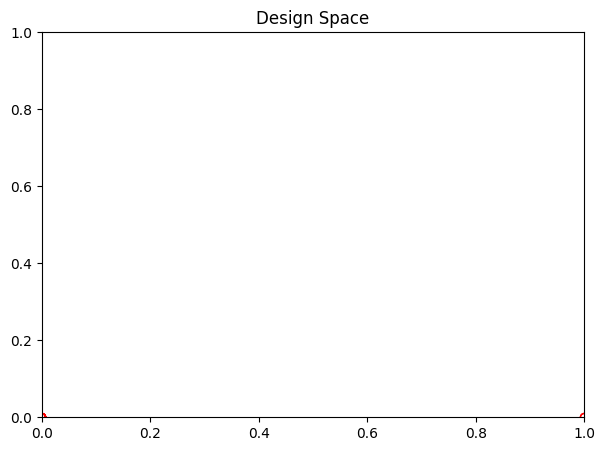

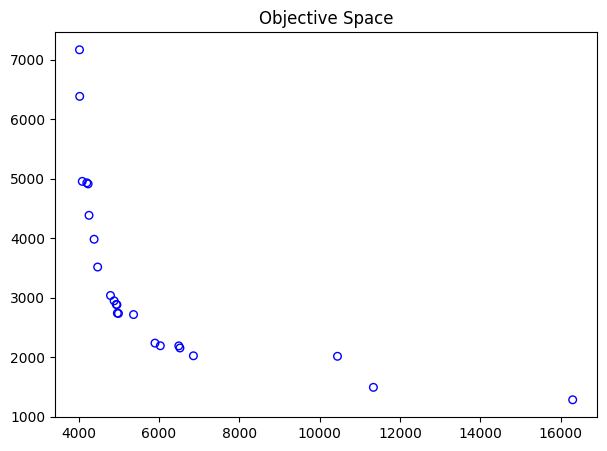

In [98]:
plotting_2d.plot_NSGA_results(X, F, nsga_problem)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})

# for x_sol in range(0,X.shape[0],4):
#     plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

def plot_explain(i):
    plotting_2d.plot_pymoo_results(X[int(i)], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

%matplotlib inline

import numpy as np

interact(plot_explain, i = widgets.FloatSlider(value=1, min=1, max=X.shape[0], step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=51.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_explain(i)>

#### Comparison of Optimization Results

Profit baseline is 66360.32150399999


,Total distance of trees to cable roads,Productivity cost per m3 as per Stampfer,Total distance from carriage to support,overall_profit,cable_road_costs,profit_comparison,name
0,35528.323566,3682.084985,42142.540802,66360.321504,558.399614,0.000000e+00,LSCP 0
1,35528.323566,3682.084985,42142.540802,66360.321504,558.399614,0.000000e+00,e-Constraint 0
2,37606.422817,4450.894894,41805.016512,66360.321504,52517.047362,1.455192e-11,e-Constraint 1
3,5366.632891,3358.939190,44787.384131,66360.321504,2717.152615,0.000000e+00,NSGA2 0
4,4385.051947,3194.206219,44855.586952,66360.321504,3468.762477,0.000000e+00,NSGA2 7
5,6856.886187,3301.841808,44623.061055,66360.321504,2023.755802,0.000000e+00,NSGA2 14
6,4883.023023,3644.426072,45006.288465,66360.321504,2898.537624,1.455192e-11,NSGA2 22


<AxesSubplot:>

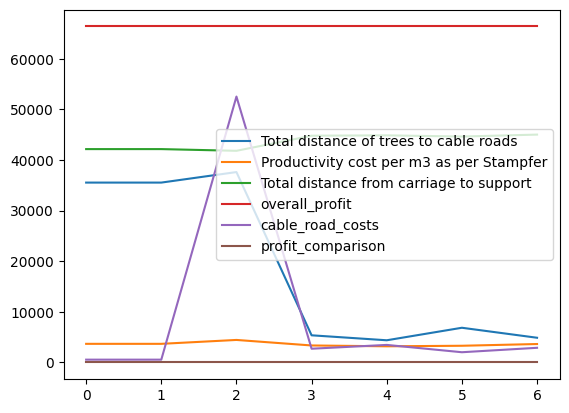

In [99]:
tree_volumes_list = harvesteable_trees_gdf["cubic_volume"]
distance_tree_line, distance_carriage_support = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, line_gdf)
sample_model = model_list[0]
reload(classes)
reload(plotting_2d)

results_df = plotting_2d.model_results_comparison(optimization_result_list, line_gdf, sample_model.aij, distance_carriage_support, sample_model.productivity_cost, tree_volumes_list)
display(results_df)
results_df.plot()

In [83]:
for result in optimization_result_list:
    plotting_2d.plot_optimization_layout(result, line_gdf, harvesteable_trees_gdf)